## Example 10.2: An Access-Control Queuing Task

This is a decision task involving **access control** to a set of **10 servers**.

---

### Problem Description

* **Queue**: Customers of **four different priorities** arrive at a single queue.
* **Rewards** (if accepted, based on customer priority):

  * Priority 1 → reward = $1$
  * Priority 2 → reward = $2$
  * Priority 3 → reward = $4$
  * Priority 4 → reward = $8$
* **Decision per time step**:

  * **Accept** → assign to a server (if available)
  * **Reject** → remove from queue (reward = $0$)

In either case, the **next customer in the queue** is considered on the following time step.

---

### Additional Details

* The queue **never empties**.
* Priorities are **uniformly randomly distributed**.
* If **no server is free**, the customer is automatically rejected.
* **Server availability**: each busy server becomes free with probability $p = 0.06$ per time step.
* **Unknown statistics**: although described above, assume the arrival and departure rates are *unknown*.
* **Goal**: decide whether to accept or reject each customer, based on:

  * Their priority
  * Number of free servers
    so as to **maximize long-term reward without discounting**.

---

### Solution Approach

Although this is a **tabular solution**, we can still view it as a **special case** of the **general function approximation** setting.

* **State**: $(\text{number of free servers},\ \text{priority of customer})$
* **Action**: accept or reject
* **Estimate**: differential action-value $\hat{q}(s, a)$ for each state–action pair.

---

### Learning Method

* **Algorithm**: differential semi-gradient Sarsa
* **Parameters**:

  * $\alpha = 0.01$ (step size)
  * $\beta = 0.01$ (average reward step size)
  * $\epsilon = 0.1$ (exploration rate)
* **Initialization**:

  * All action values = $0$
  * Average reward $\bar{R} = 0$


In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt

ACTIONS = ['accept', 'reject']
FREE_SERVERS_BOUNDS = (0, 10)
PRIORITY_BOUNDS = (0, 3)
# Use exactly one tiling sized to the discrete grid: priorities 0..3 (rows=4), free servers 0..10 (cols=11)
TILING_ROWS_AND_COLS = (4, 11)
TILING_OFFSETS = [
    (0.0, 0.0)
]
NUM_FEATURES = len(TILING_OFFSETS) * TILING_ROWS_AND_COLS[0] * TILING_ROWS_AND_COLS[1]
NUM_ACTION_FEATURES = NUM_FEATURES * len(ACTIONS)

# all inputs are tuples
def get_tile_vector(
    state,
    space_x_range=FREE_SERVERS_BOUNDS,
    space_y_range=PRIORITY_BOUNDS,
    tile_rows_and_cols=TILING_ROWS_AND_COLS,
    offset=TILING_OFFSETS[0]
):
    rows, cols = tile_rows_and_cols
    num_tiles = rows * cols
    tile_width = (space_x_range[1] - space_x_range[0]) / cols
    tile_height = (space_y_range[1] - space_y_range[0]) / rows

    # offset is fraction of a tile in each dimension (e.g., 0.5 = half-tile shift)
    offset_x_world = offset[0] * tile_width
    offset_y_world = offset[1] * tile_height

    x, y = state
    x_min, _ = space_x_range
    y_min, _ = space_y_range

    col = math.floor((x - x_min + offset_x_world) / tile_width)
    row = math.floor((y - y_min + offset_y_world) / tile_height)

    col = max(0, min(cols - 1, col))
    row = max(0, min(rows - 1, row))

    tile_vector = np.zeros(num_tiles)
    tile_vector[row * cols + col] = 1
    return tile_vector

def get_feature_vector(
    state, 
    space_x_range=FREE_SERVERS_BOUNDS, 
    space_y_range=PRIORITY_BOUNDS, 
    tile_rows_and_cols=TILING_ROWS_AND_COLS, 
    offsets=TILING_OFFSETS
):
    feature_vectors = []
    for i, offset in enumerate(offsets):
        feature_vectors.append(get_tile_vector(state, space_x_range, space_y_range, tile_rows_and_cols, offset))
    return np.concatenate(feature_vectors)

def get_action_feature_vector(state, action):
    state_feature_vector = get_feature_vector(state, FREE_SERVERS_BOUNDS, PRIORITY_BOUNDS, TILING_ROWS_AND_COLS, TILING_OFFSETS)
    action_feature_vector = np.zeros(NUM_ACTION_FEATURES)
    action_index = ACTIONS.index(action)
    start = action_index * NUM_FEATURES
    end = start + NUM_FEATURES
    action_feature_vector[start:end] = state_feature_vector
    return action_feature_vector

def priority_update():
    random_number = np.random.random()
    if random_number < .25:
        return 0
    elif random_number < .5:
        return 1
    elif random_number < .75:
        return 2
    else:
        return 3

def free_servers_update(free_servers, action):
    # Completions come only from servers that were busy at the start of the step
    busy_before_action = 10 - free_servers
    freed = np.random.binomial(busy_before_action, 0.06)

    # Apply completions, then apply acceptance (newly accepted job cannot complete this same step)
    free_after_completions = min(10, free_servers + freed)
    if action == 'accept' and free_servers > 0:
        free_after_completions -= 1

    return max(0, min(10, free_after_completions))

def update_state(state, action):
    free_servers, _ = state
    # Automatic rejection if no server is free
    effective_action = action if (action == 'accept' and free_servers > 0) else 'reject'
    new_free_servers = free_servers_update(free_servers, effective_action)
    new_priority = priority_update()
    return (new_free_servers, new_priority)

def get_reward(state, action):
    free_servers, priority = state
    # Reward is for the current customer and only if accepted with a free server
    if action == 'accept' and free_servers > 0:
        if priority == 0:
            return 1
        elif priority == 1:
            return 2
        elif priority == 2:
            return 4
        else:
            return 8
    return 0
        
def get_next_state_and_reward(state, action):
    reward = get_reward(state, action)
    new_state = update_state(state, action)
    return new_state, reward

def get_start_state():
    return (np.random.randint(FREE_SERVERS_BOUNDS[0], FREE_SERVERS_BOUNDS[1] + 1), np.random.randint(PRIORITY_BOUNDS[0], PRIORITY_BOUNDS[1] + 1))

def get_action_value(state, action, w):
    feature_vector = get_action_feature_vector(state, action)
    return np.dot(w, feature_vector)

def get_action_values(state, w):
    state_feature_vector = get_feature_vector(state, FREE_SERVERS_BOUNDS, PRIORITY_BOUNDS, TILING_ROWS_AND_COLS, TILING_OFFSETS)
    values = []
    for i in range(len(ACTIONS)):
        start = i * NUM_FEATURES
        end = start + NUM_FEATURES
        w_slice = w[start:end]
        values.append(np.dot(w_slice, state_feature_vector))
    return values

def get_next_action(w, state, epsilon):
    # Automatic rejection when no servers are free
    if state[0] == 0:
        return 'reject'
    action_values = get_action_values(state, w)
    best_action = ACTIONS[np.argmax(action_values)]
    if np.random.random() < epsilon:
        return np.random.choice(ACTIONS)
    else:
        return best_action

def get_best_action(w, state):
    action_values = get_action_values(state, w)
    return ACTIONS[np.argmax(action_values)]

def train_semi_gradient_sarsa(alpha, beta, epsilon, steps):
    w = np.zeros(NUM_ACTION_FEATURES)
    avg_reward = 0
    state = get_start_state()
    action = get_next_action(w, state, epsilon)
    for step in range(steps):
        next_state, reward = get_next_state_and_reward(state, action)
        next_action = get_next_action(w, next_state, epsilon)
        delta = reward - avg_reward + get_action_value(next_state, next_action, w) - get_action_value(state, action, w)
        avg_reward += beta * delta
        w += alpha * delta * get_action_feature_vector(state, action)
        state = next_state
        action = next_action
    
    return w, avg_reward

def compute_policy_grid(w):
    # Rows: priorities 0..3 (display labels 1,2,4,8). Cols: free servers 1..10.
    grid = np.zeros((4, 10), dtype=int)
    for priority in range(4):
        for free_servers in range(1, 11):
            state = (free_servers, priority)
            action_values = get_action_values(state, w)
            best_action_index = int(np.argmax(action_values))  # 0=accept, 1=reject
            # Map to 1 for accept (blue), 0 for reject (red)
            grid[priority, free_servers - 1] = 1 if ACTIONS[best_action_index] == 'accept' else 0
    return grid

def plot_policy_grid(policy_grid):
    fig, ax = plt.subplots(figsize=(10, 4))
    cmap = plt.cm.get_cmap('bwr_r', 2)  # 0 -> red (reject), 1 -> blue (accept)
    im = ax.imshow(policy_grid, cmap=cmap, origin='upper', vmin=0, vmax=1)

    ax.set_xlabel('Number of free servers')
    ax.set_ylabel('Priority')
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(np.arange(1, 11))
    ax.set_yticks(np.arange(4))
    ax.set_yticklabels([1, 2, 4, 8])

    # Draw grid lines
    ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 4, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Legend
    from matplotlib.patches import Patch
    legend_handles = [
        Patch(facecolor=cmap(0), edgecolor='black', label='REJECT'),
        Patch(facecolor=cmap(1), edgecolor='black', label='ACCEPT'),
    ]
    ax.legend(handles=legend_handles, loc='upper right', frameon=True)

    plt.tight_layout()
    plt.show()

2.8063410792357666


/var/folders/1f/gpv23w7n01x6ppgkwtxfhsx80000gn/T/ipykernel_78398/2699926639.py:180: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('bwr_r', 2)  # 0 -> red (reject), 1 -> blue (accept)


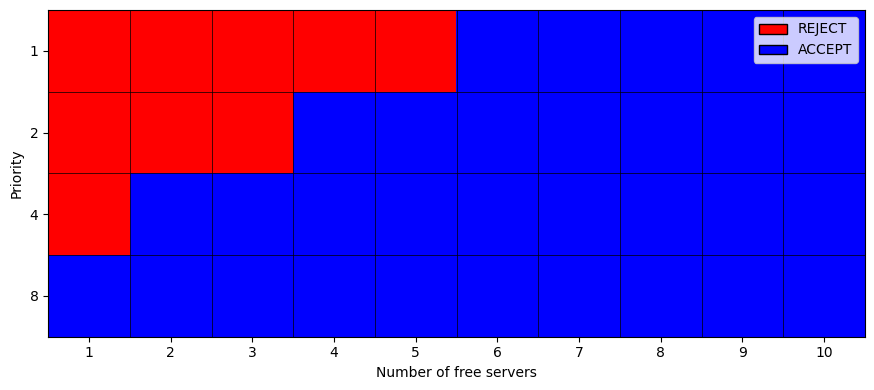

In [11]:
w, avg_reward = train_semi_gradient_sarsa(alpha=.01, beta=.01, epsilon=.1, steps=2_000_000)
print(avg_reward)

# Compute and plot learned policy over priorities (rows) and free servers 1..10 (cols)
policy_grid = compute_policy_grid(w)
plot_policy_grid(policy_grid)